In [1]:
%load_ext autoreload
%autoreload 2

# Import and Setup

In [12]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import gc
import pprint
import numpy as np
import pandas as pd
from tqdm import tqdm
from functools import partial
from argparse import Namespace
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *


import wandb
from wandb.keras import WandbCallback

from model import SimpleSupervisedtModel, ArcFaceSupervisedModel, get_feature_extractor
from config import get_train_config
from data import GetDataloader
from utils import ShowBatch, id_generator
from callbacks import GetCallbacks

pp = pprint.PrettyPrinter(indent=1)

In [4]:
args = get_train_config()

random_id = id_generator(size=8)
args.exp_id = random_id

pp.pprint(vars(args))

{'batch_size': 256,
 'early_patience': 6,
 'embedding_save_path': '../embeddings',
 'epochs': 30,
 'exp_id': 'LULWXXB4',
 'image_height': 128,
 'image_width': 128,
 'labels': {'beluga': 4,
            'blue_whale': 7,
            'bottlenose_dolphin': 3,
            'brydes_whale': 19,
            'commersons_dolphin': 20,
            'common_dolphin': 10,
            'cuviers_beaked_whale': 17,
            'dusky_dolphin': 13,
            'false_killer_whale': 2,
            'fin_whale': 6,
            'frasiers_dolphin': 25,
            'gray_whale': 8,
            'humpback_whale': 1,
            'killer_whale': 11,
            'long_finned_pilot_whale': 14,
            'melon_headed_whale': 0,
            'minke_whale': 5,
            'pantropic_spotted_dolphin': 23,
            'pygmy_killer_whale': 24,
            'rough_toothed_dolphin': 22,
            'sei_whale': 15,
            'short_finned_pilot_whale': 12,
            'southern_right_whale': 9,
            'spinner_dolphi

In [5]:
DEBUG = True

# Prepare Dataset

In [6]:
df = pd.read_csv('../cleaned_5_fold_train.csv')
print('Num Labels:', args.num_labels)
df.head()

Num Labels: 26


,image,species,individual_id,img_path,target,fold
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,../128x128/train_images-128-128/train_images-1...,0,2.0
1,000562241d384d.jpg,humpback_whale,1a71fbb72250,../128x128/train_images-128-128/train_images-1...,1,3.0
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b,../128x128/train_images-128-128/train_images-1...,2,2.0
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063,../128x128/train_images-128-128/train_images-1...,3,2.0
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392,../128x128/train_images-128-128/train_images-1...,1,4.0


# Dataloader

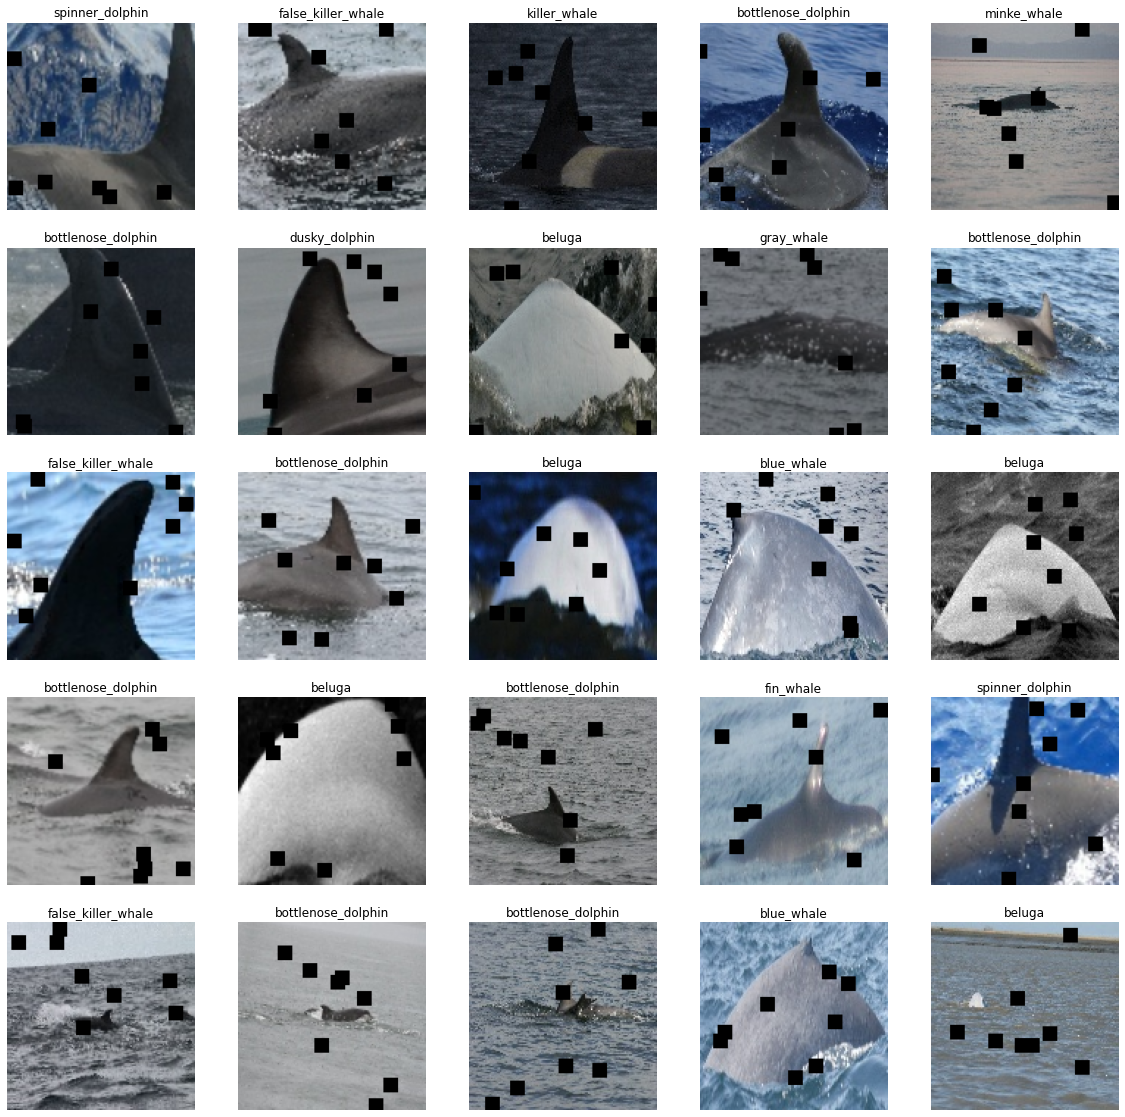

In [15]:
# Sanity check
if DEBUG:
    # Get Split
    train_df = df[df.fold != 0]
    valid_df = df[df.fold == 0]

    # Get train and validation loaders
    dataset = GetDataloader(args)
    trainloader = dataset.dataloader(train_df, data_type='train')
    validloader = dataset.dataloader(valid_df, data_type='valid')

    # Display a batch
    if args.use_arcface:
        sample_inputs, sample_labels = next(iter(trainloader))
        sample_imgs, sample_labels = sample_inputs['img_input'], sample_inputs['label_input']
    else:
        sample_imgs, sample_labels = next(iter(trainloader))

    show_batch = ShowBatch(args)
    show_batch.show_batch(sample_imgs, sample_labels)

# Model

In [16]:
if DEBUG:
    tf.keras.backend.clear_session()
    
    if args.use_arcface:
        get_model = ArcFaceSupervisedModel(args)
    else:
        get_model = SimpleSupervisedtModel(args)
        
    model = get_model.get_efficientnet()
    model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 26)                33306     
Total params: 4,082,877
Trainable params: 4,040,854
Non-trainable params: 42,023
_________________________________________________________________


# Callbacks

In [17]:
callbacks = GetCallbacks(args)

# Train

In [18]:
if DEBUG:
    args.epochs = 10
    args.num_folds = 1

for fold in range(args.num_folds):
    # Get dataloaders
    train_df = df[df.fold != fold]
    valid_df = df[df.fold == fold]

    dataset = GetDataloader(args)
    trainloader = dataset.dataloader(train_df)
    validloader = dataset.dataloader(valid_df, data_type='valid')
    
    # Initialize model
    tf.keras.backend.clear_session()
    if args.use_arcface:
        get_model = ArcFaceSupervisedModel(args)
    else:
        get_model = SimpleSupervisedtModel(args)
        
    model = get_model.get_efficientnet()

    # Compile model
    optimizer = 'adam'
    if args.use_arcface:
        loss = 'binary_crossentropy'
    else:
        loss = 'categorical_crossentropy'
        
    model.compile(optimizer,
                  loss=loss,
                  metrics=['acc',
                           tf.keras.metrics.TopKCategoricalAccuracy(1, name='top@1_acc'),
                           tf.keras.metrics.TopKCategoricalAccuracy(5, name='top@5_acc')])

    # Initialize W&B run
    run = wandb.init(project='happywhale',
                     config=vars(args),
                     group=f'effnetb0-{args.exp_id}',
                     job_type='train',
                     name=f'{args.exp_id}_{fold}_train')

    # Train
    model.fit(trainloader,
              epochs=args.epochs,
              validation_data=validloader,
              callbacks=[WandbCallback(save_model=False),
                         callbacks.get_reduce_lr_on_plateau()])
    
    # Save the model
    os.makedirs(f'{args.model_save_path}/{args.exp_id}', exist_ok=True)
    model.save(f'{args.model_save_path}/{args.exp_id}/model_{fold}')
    
    # Load the model
    model = tf.keras.models.load_model(f'{args.model_save_path}/{args.exp_id}/model_{fold}')
    
    # Evaluate and prepare oof 
    preds = model.predict(validloader)
    df.loc[list(df[df.fold == fold].index), 'preds'] = np.argmax(preds, axis=1)
    
    # Get Embedding and save it as npz files along with validation index
    feature_extractor = get_feature_extractor(model)
    embedding = feature_extractor.predict(validloader)

    os.makedirs(f'{args.embedding_save_path}/{args.exp_id}', exist_ok=True)
    np.savez(f'{args.embedding_save_path}/{args.exp_id}/embedding_{fold}.npz',
             embedding=embedding,
             index=np.array(valid_df.index))
    
    del trainloader, validloader, model, feature_extractor, embedding
    _ = gc.collect()

    # Close W&B run
    run.finish()
    
df[['image', 'individual_id', 'target', 'preds']].to_csv('../oof.csv', index=False)

wandb: Currently logged in as: ayut (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/10
160/160 [==============================] - 75s 401ms/step - loss: 0.7984 - acc: 0.7648 - top@1_acc: 0.7648 - top@5_acc: 0.9443 - val_loss: 0.3962 - val_acc: 0.8727 - val_top@1_acc: 0.8727 - val_top@5_acc: 0.9876
Epoch 2/10
160/160 [==============================] - 58s 361ms/step - loss: 0.3436 - acc: 0.8896 - top@1_acc: 0.8896 - top@5_acc: 0.9914 - val_loss: 0.3008 - val_acc: 0.9033 - val_top@1_acc: 0.9033 - val_top@5_acc: 0.9921
Epoch 3/10
160/160 [==============================] - 58s 363ms/step - loss: 0.2456 - acc: 0.9199 - top@1_acc: 0.9199 - top@5_acc: 0.9964 - val_loss: 0.2447 - val_acc: 0.9203 - val_top@1_acc: 0.9203 - val_top@5_acc: 0.9947
Epoch 4/10
160/160 [==============================] - 59s 366ms/step - loss: 0.2010 - acc: 0.9338 - top@1_acc: 0.9338 - top@5_acc: 0.9972 - val_loss: 0.2407 - val_acc: 0.9256 - val_top@1_acc: 0.9256 - val_top@5_acc: 0.9955
Epoch 5/10
160/160 [==============================] - 58s 362ms/step - loss: 0.1694 - acc: 0.9446 - top@1_ac

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


acc,▁▅▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▃▂▂▁▁▁▁▁
top@1_acc,▁▅▆▇▇▇████
top@5_acc,▁▇████████
val_acc,▁▄▆▇▇▇█▇██
val_loss,█▄▂▁▂▁▁▁▁▁
val_top@1_acc,▁▄▆▇▇▇█▇██
val_top@5_acc,▁▅▇█▆█████
acc,0.96835
best_epoch,6


In [20]:
oof_df = pd.read_csv('../oof.csv')
oof_df_copy = oof_df.copy()

def correct_preds(row):
    return int(row.preds)

oof_df_copy['preds'] = oof_df_copy.apply(lambda row: correct_preds(row), axis=1)

metric = tf.keras.metrics.SparseCategoricalCrossentropy()
metric.update_state(oof_df_copy.target.values.reshape(-1,1), oof_df_copy.preds.values.reshape(-1,1))
print(f'CV Score: {metric.result().numpy()}')

In [52]:
oof_df_copy[oof_df_copy.target == oof_df_copy.preds]

,image,species,individual_id,img_path,target,fold,preds
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,../128x128/train_images-128-128/train_images-1...,0,2.0,0
1,000562241d384d.jpg,humpback_whale,1a71fbb72250,../128x128/train_images-128-128/train_images-1...,1,3.0,1
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b,../128x128/train_images-128-128/train_images-1...,2,2.0,2
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063,../128x128/train_images-128-128/train_images-1...,3,2.0,3
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392,../128x128/train_images-128-128/train_images-1...,1,4.0,1
...,...,...,...,...,...,...,...
51027,fff603f5af8614.jpg,fin_whale,40fe65946167,../128x128/train_images-128-128/train_images-1...,6,3.0,6
51028,fff639a7a78b3f.jpg,beluga,5ac053677ed1,../128x128/train_images-128-128/train_images-1...,4,4.0,4
51030,fff94675cc1aef.jpg,blue_whale,5401612696b9,../128x128/train_images-128-128/train_images-1...,7,3.0,7
51031,fffbc5dd642d8c.jpg,beluga,4000b3d7c24e,../128x128/train_images-128-128/train_images-1...,4,0.0,4
